In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
import os
from vocab import Vocabulary, deserialize_vocab  # NOQA
import evaluation
import data
import torch
from train import validate
from model import SCAN
from data import get_loaders
from tqdm import tqdm
from PIL import Image
import json 
from glob import glob
import numpy as np
from model import l2norm
from evaluation import encode_data_vector
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.rc('font', family='Arial')
# matplotlib.rcParams['font.fantasy'] = 'Ubuntu'
from torchvision import transforms

/home/jonatas/.conda/envs/xd/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
model_path = '../runs/en/gru_en/model_best.pth.tar'

In [4]:
# load model and options
checkpoint = torch.load(model_path)
opt = checkpoint['opt']
model = SCAN(opt)
model.load_state_dict(checkpoint['model'])
model.val_start()


EncoderImagePrecomp(
  (fc): Linear(in_features=2048, out_features=1024, bias=True)
)
()
EncoderText(
  (embed): Embedding(18205, 300)
  (rnn): GRU(300, 1024, batch_first=True, bidirectional=True)
)


In [5]:
vocab = deserialize_vocab(os.path.join('../',opt.vocab_path))

In [6]:
with open('/opt/datasets/flickr/dataset_flickr30k.json', 'r') as fp:
    flickr = json.load(fp)
    f30k = {x['filename']: x for x in flickr['images']}

In [7]:
print('Loading dataset')
loader_en, loader_de = get_loaders(
    splits=['test', 'test'], 
    langs=['en', 'de'],
    data_name=opt.data_name, 
    vocab=vocab,
    batch_size=opt.batch_size, 
    workers=opt.workers, opt=opt,
)

Loading dataset


In [8]:
features = glob('/opt/datasets/flickr_features/pickles/*.pkl')
features = {fname.split('/')[-1][:-3]: fname for fname in features}

In [9]:
def get_instance(loader, idx):
    instance = loader.dataset[idx]
    instance = data.collate_fn_partial_inst(instance)
    img_id = loader.dataset.ids[idx]
    inst_dict = flickr['images'][int(img_id)]
    doug_features = np.load(features[inst_dict['filename'][:-3]])
    return instance, inst_dict, doug_features

In [10]:
instance, f30k_info, doug_features = get_instance(loader_en, 2)
images, captions, _, lengths, ids = instance
images = images.cuda()
captions = captions.cuda().long()


In [11]:
# image 2 text
img_embs, cap_embs = encode_data_vector(model, loader_en)
# img_embs = numpy.array([img_embs[i] for i in range(0, len(img_embs), 5)])
print img_embs.shape, cap_embs.shape

Test: [0/40]		Time 0.079 (0.000)	
Test: [10/40]		Time 0.087 (0.000)	
Test: [20/40]		Time 0.059 (0.000)	
Test: [30/40]		Time 0.081 (0.000)	
(5000, 1024) (5000, 1024)


In [12]:
sims = img_embs.dot(cap_embs.transpose(1, 0))

In [13]:
def retrieve_caption(cap_idx):
    sims_t = sims.T
    sims_t1k = sims_t[:, range(0, sims_t.shape[1], 5)]
    inds = np.argsort(sims_t1k, axis=1)[:, ::-1]

    ld = loader_en

    _caption = cap = ld.dataset.captions[cap_idx]
    print cap

    n = 10
    if cap.endswith('.'):
        cap = cap[:-2]
    split_str = cap.split(' ')
    if len(split_str) > n:
        for j in range(n, len(split_str), n):
            split_str[j-1] += '\n   '
    cap = ' '.join(split_str)
    cap = '{}: {}'.format('Query', cap)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.gca().set_axis_off()
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.axis('off')
    plt.subplots_adjust(bottom=0, top=1, left=0, right=1, wspace=0, hspace=0)


    ax.set_axis_off()
    fig.add_axes(ax)

    imgs = []
    preds = []
    for i in range(0, 3):
        img_idx = inds[cap_idx, i] * 5
        pred = cap_idx in range(img_idx, img_idx + 5)
        preds.append(pred)

        # restore original indexes
        img_id = int(ld.dataset.ids[img_idx])
        img_info = flickr['images'][img_id]
        img = Image.open(os.path.join('/opt/datasets/flickr/flickr30k_images', img_info['filename']))
        crop = transforms.CenterCrop(max(img.size))
        img = crop(img).resize((400,400))
        img = np.asarray(img)
        if i < 2:
            img = np.pad(img, [[0,0], [0,50], [0,0]], mode='constant', constant_values=255)
        imgs.append(img)

    imgs = np.hstack(imgs)
    ax.imshow(imgs)
    plt.text(imgs.shape[1]/2., -30, unicode(cap, 'utf-8'), fontsize=10, horizontalalignment='center')
    first = 200
    for i in range(3):
        symb = '$\checkmark$' if preds[i] else '$\\times$'
        plt.text(first, img.shape[0] + 35, symb, fontsize=15, horizontalalignment='center')
        first += 450
    # plt.savefig('t2i_imgs/t2i_de_{}.pdf'.format(cap_idx), bbox_inches='tight', dpi=166, pad_inches=0)
    plt.show()
    return _caption



The man with pierced ears is wearing glasses and an orange hat .


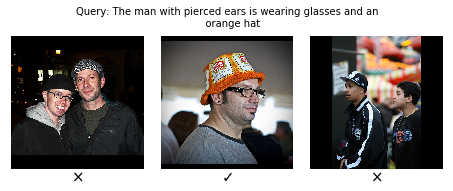

In [14]:
_ = retrieve_caption(0)

Six people ride mountain bikes through a jungle environment .


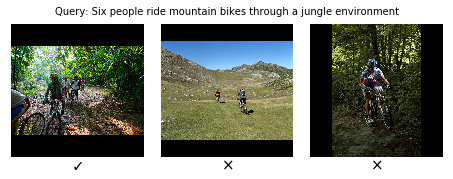

In [15]:
_ = retrieve_caption(150)

A young child walks down a gravel path lined with a row of red outdoor chairs .


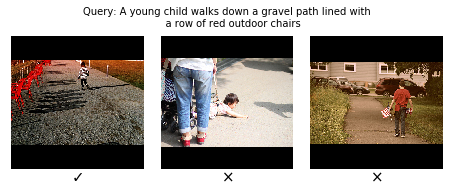

In [16]:
_ = retrieve_caption(550)

A young girl dancing in her socks on a wooden floor strewn with pink balloons .


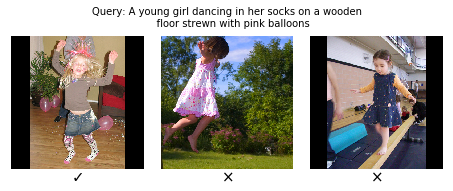

In [17]:
_ = retrieve_caption(720)

A man in a green hard hat and yellow vest is looking down .


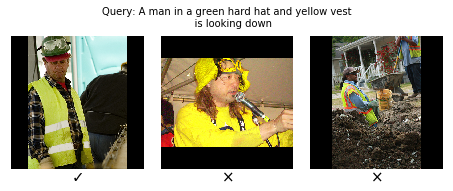

In [18]:
_ = retrieve_caption(715)

A man in a white shirt playing a white guitar standing in front of a microphone with the light casting a somewhat reddish hue on his shirt


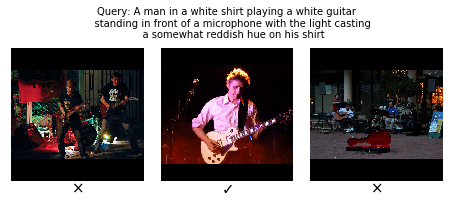

In [19]:
_ = retrieve_caption(4200)

In [59]:
img_embs = img_embs[np.arange(0, 5000, 5)]

In [60]:
img_sim = img_embs.dot(img_embs.transpose(1, 0))

In [61]:
idxs = img_sim.argsort()[:, ::-1]

In [62]:
img_sim.shape

(1000, 1000)

In [156]:
imgs = []
for j in range(1, len(idxs)):
    ids = idxs[j,:] * 5
    ids 
    for i in range(10):
        img_id = int(loader_en.dataset.ids[int(ids[i])])
        print(img_id)
        img_info = flickr['images'][img_id]
        img = Image.open(os.path.join('/opt/datasets/flickr/flickr30k_images', img_info['filename']))
        imgs.append(img)
    break

34
14332
13276
2124
9065
23128
17823
18979
11939
22548


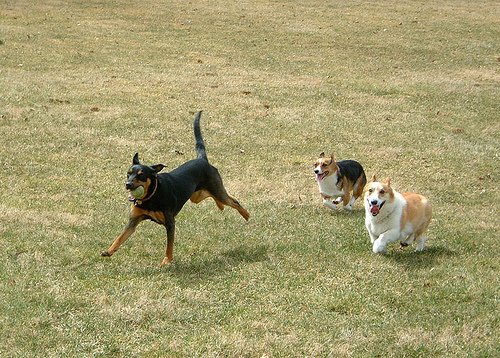

In [169]:
imgs[7]

In [ ]:
def tokenize_text(caption):
    import nltk 
    from txt2char import Text2Char 
    # Convert caption (string) to word ids.
    tokens = nltk.tokenize.word_tokenize(
        str(caption).lower().decode('utf-8')
    )
    caption = []
    caption.append(vocab('<start>'))
    caption.extend([vocab(token) for token in tokens])
    caption.append(vocab('<end>'))
    target = torch.Tensor(caption)
    return target

In [ ]:
text = 'a cat'

In [ ]:
# def retrieve_image(text):

tokens = [tokenize_text(text)]
tokens, lens = data.pad_default(tokens)
tokens = tokens.cuda().long()
embed, lens = model.txt_enc(tokens, lens)
print(embed.shape)
embed = l2norm(embed, 2) 
embed = l2norm(embed.mean(1), 1) 
caption_embed = embed.cpu().data.numpy()

sim = img_embs.dot(caption_embed.T).squeeze()
idxs = sim.argsort()[::-1]
print(sim.shape, idxs.shape)

In [ ]:
for _id in idxs[:3]:
    img_id = int(loader_en.dataset.ids[int(_id)])
    
    img_info = flickr['images'][img_id]
    img = Image.open(os.path.join('/opt/datasets/flickr/flickr30k_images', img_info['filename']))

In [ ]:
img


In [ ]:
retrieve_image(
'''
a giraffe 
'''
)